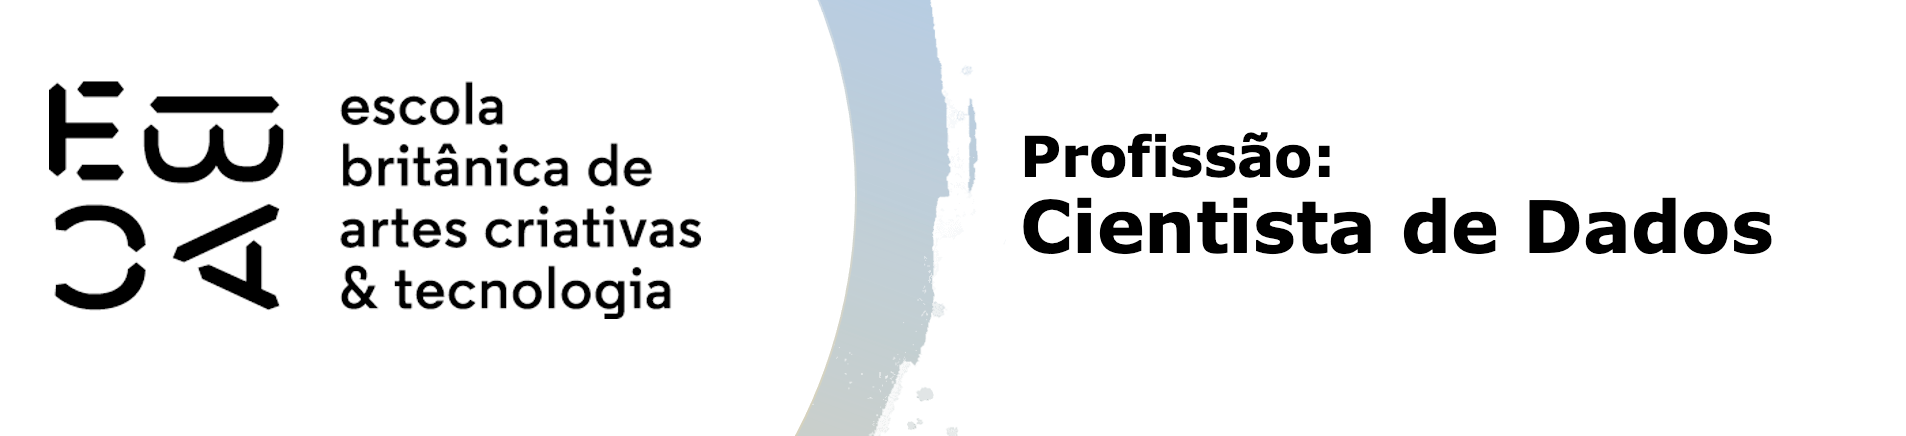

# Tarefa

Com base na tarefa realizada no módulo anterior, vamos fazer um diagnóstico do modelo.

Carregue a base ```previsao_de_renda2.csv```. Separe em uma base de treino e uma base de teste.

Vamos resgatar a melhor versão do modelo de previsão de renda que você fez para esta base. 

- Substitua missings pela média
- Rode novamente o modelo na base de treino (ou desenvolva-o caso não tenha o registro guardado). 

Este modelo deve prever a variável ```renda``` com base nas demais variáveis exceto ```data_ref``` e ```index```. Já vimos que a variável renda é melhor modelada com a transformação ```log()```, não se esqueça disso.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings
import scipy.stats as st

from scipy.interpolate import interp1d

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

%matplotlib inline

sns.set_palette('colorblind')

In [2]:
df = pd.read_csv('./data/input/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [3]:
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [4]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())

In [5]:
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Separando em treino e teste

In [6]:
print(df.index.min())
print(df.index.max())

2015-01-01
2016-03-01


In [7]:
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

In [8]:
df_train['log_renda'] = np.log(df_train['renda'])
df_test['log_renda'] = np.log(df_test['renda'])

warnings.filterwarnings('ignore')

C:\Users\Joao Narciso Santos\AppData\Local\Temp\ipykernel_14484\441431739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_renda'] = np.log(df_train['renda'])
C:\Users\Joao Narciso Santos\AppData\Local\Temp\ipykernel_14484\441431739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_renda'] = np.log(df_test['renda'])


In [9]:
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel) 
                    + qtd_filhos 
                    + idade
                    + tempo_emprego 
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 1.131e+05
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:08:37   Log-Likelihood:            -8.0162e+05
No. Observations:              600000   AIC:                         1.603e+06
Df Residuals:                  599996   BIC:                         1.603e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.2219      0.005   1661.668      0.000       8.212       8.232
C(posse_de_imovel)[T.S]     0.1812      0.003     70.949      0.000       0.176       0.186
qtd_filhos                       0          0        nan        nan           0           0
idade                      -0.0008      0.000     -7.364      0.000      -0.001      -0.001
tempo_emprego               0.1300      0.000    658.747      0.000       0.130       0.130
==============================================================================
Omnibus:                      973.028   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              860.618
Skew:                          -0.049   Prob(JB):                    1.32e-187
Kurtosis:                       2.842   Cond. No.                         218.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
X1 = patsy.dmatrices('''log_renda ~ C(posse_de_imovel)
                    + tempo_emprego
                    + 1''', df_train)

res = smf.ols(X1, data=df_train).fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=0.05)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 1.508e+05
Date:                Fri, 02 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:08:46   Log-Likelihood:            -8.0165e+05
No. Observations:              600000   AIC:                         1.603e+06
Df Residuals:                  599997   BIC:                         1.603e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   8.1906      0.003   3232.604      0.000       8.186       8.196
C(posse_de_imovel)[T.S]     0.1786      0.003     70.599      0.000       0.174       0.184
tempo_emprego               0.1297      0.000    669.360      0.000       0.129       0.130
==============================================================================
Omnibus:                      965.677   Durbin-Watson:                   1.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              854.301
Skew:                          -0.049   Prob(JB):                    3.10e-186
Kurtosis:                       2.843   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Verifique as suposições do modelo

Faça uma análise para avaliar as suposições básicas:

- Os resíduos desse modelo possuem distribuição Normal (ou algo próximo)?
- Verifique a independência dos resíduos
    - Faça um gráfico dos resíduos versus os valores preditos
    - Avalie se há padrões dos resíduos versus cada uma das variáveis do modelo
    - Avalie se o valor médio dos resíduos aparenta ter relação com o mês de referência
- Avalie se a variância da variável resposta parece ser conforme os valores previstos.

Você considera que as suposições estão atendidas? Há algum impacto em eventuais desvios?

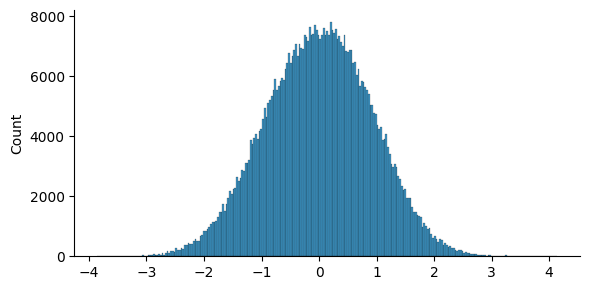

In [11]:
sns.displot(res.resid, height=3, aspect=2)

<AxesSubplot: ylabel='log_renda'>

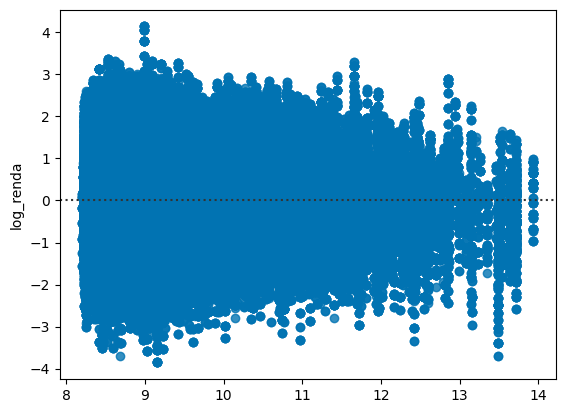

In [12]:
sns.residplot(x=res.predict(), y='log_renda', data=df_train)

<AxesSubplot: ylabel='posse_de_imovel'>

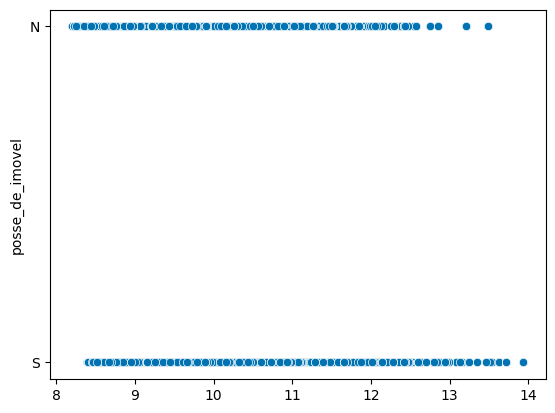

In [13]:
sns.scatterplot(x=res.predict(), y='posse_de_imovel', data=df_train)

<AxesSubplot: ylabel='tempo_emprego'>

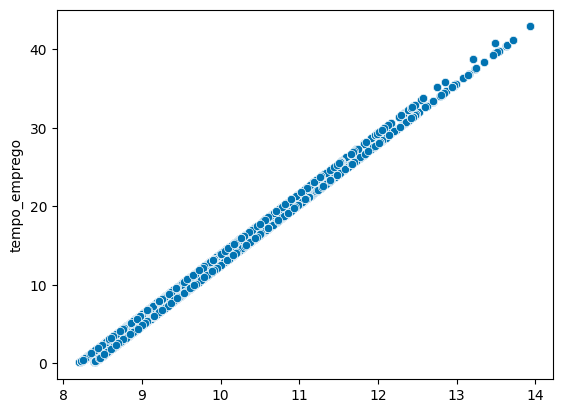

In [14]:
sns.scatterplot(x=res.predict(), y='tempo_emprego', data=df_train)

<AxesSubplot: ylabel='data_ref'>

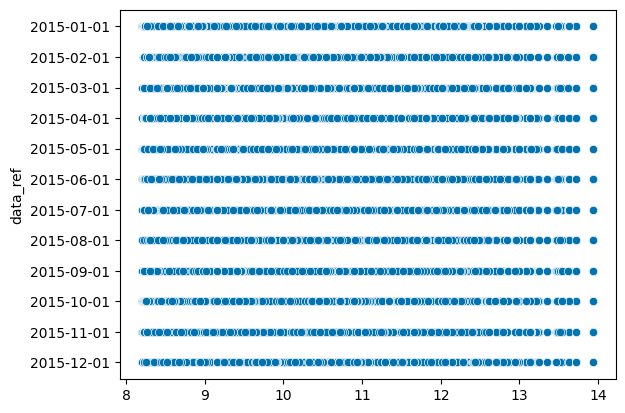

In [15]:
sns.scatterplot(x=res.predict(), y='data_ref', data=df_train)

<AxesSubplot: >

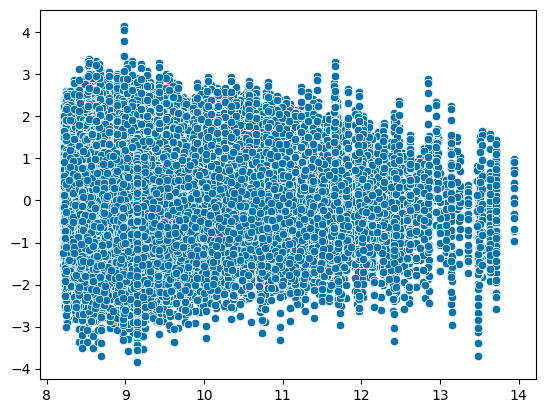

In [16]:
sns.scatterplot(x=res.predict(), y=res.resid)

## Outliers

Avalie os *studentized residuals*, verifique se há pontos que parecem ser discrepantes.

Avalie se há pontos influentes.

In [17]:
df_train_short = df_train[:'2015-02-01']
df_train_short.reset_index(inplace=True)
df_train_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   data_ref               100000 non-null  object 
 1   index                  100000 non-null  int64  
 2   sexo                   100000 non-null  object 
 3   posse_de_veiculo       100000 non-null  object 
 4   posse_de_imovel        100000 non-null  object 
 5   qtd_filhos             100000 non-null  int64  
 6   tipo_renda             100000 non-null  object 
 7   educacao               100000 non-null  object 
 8   estado_civil           100000 non-null  object 
 9   tipo_residencia        100000 non-null  object 
 10  idade                  100000 non-null  int64  
 11  tempo_emprego          100000 non-null  float64
 12  qt_pessoas_residencia  100000 non-null  float64
 13  renda                  100000 non-null  float64
 14  log_renda              100000 non-nul

In [18]:
reg = smf.ols('log_renda ~ tempo_emprego + posse_de_imovel', data=df_train_short).fit()

Text(0, 0.5, 'Resíduo')

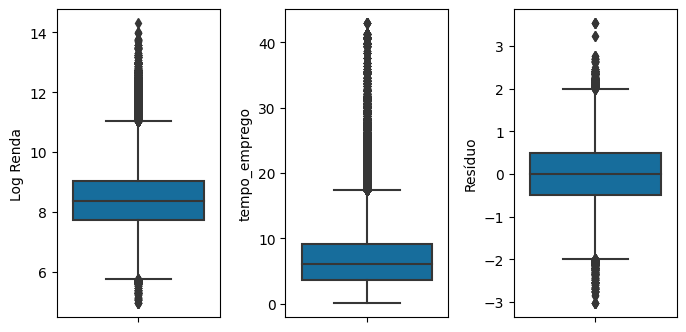

In [19]:
fix, ax = plt.subplots(1, 3, figsize=(8, 4))
plt.subplots_adjust(wspace=.4, hspace=0)

sns.boxplot(y='log_renda', data=df_train_short, ax=ax[0])
sns.boxplot(y='tempo_emprego', data=df_train_short, ax=ax[1])
sns.boxplot(y=reg.resid, data=df, ax=ax[2])

ax[0].set_ylabel('Log Renda')
ax[2].set_ylabel('Tempo Emprego')
ax[2].set_ylabel('Resíduo')

<strong>Análise:</strong> o gráfico de resíduos está bem homogênio e com a análise do boxplot, é possível observar outliers, entretanto, nenhum parece influenciar nos dados.

Obs.: não farei um regplot, existem muitos pontos e o tempo de processamento será de horas.

## Multicolinearidade

Avalie se há questões relacionadas a multicolinearidade através de pelo menos:

- Matriz de correlação de Spearman
- VIF

In [20]:
df_train_cut = df_train[['posse_de_imovel', 'tempo_emprego', 'log_renda']]
df_train_cut.head(2)

,posse_de_imovel,tempo_emprego,log_renda
data_ref,,,
2015-01-01,N,16.717808,9.318131
2015-01-01,N,9.600000,7.793508


In [34]:
# Correlação de *Spearman*

df_train_cut.corr(method='spearman')

,tempo_emprego,log_renda
tempo_emprego,1.000000,0.541167
log_renda,0.541167,1.000000


In [35]:
# VIF

variaveis = ['tempo_emprego', 'posse_de_imovel']

df_train_cut_dum = pd.get_dummies(df_train_cut[variaveis], drop_first=True)
df_train_cut_dum.head()

,tempo_emprego,posse_de_imovel_S
data_ref,,
2015-01-01,16.717808,0
2015-01-01,9.600000,0
2015-01-01,8.208219,0
2015-01-01,1.301370,1
2015-01-01,1.254795,1


In [36]:
vif(df_train_cut_dum.values, 1)

1.6611758097132379

In [37]:
vars_vif = pd.DataFrame()
vars_vif["VIF Factor"] = [vif(df_train_cut_dum, i) for i in range(df_train_cut_dum.shape[1])]
vars_vif["Feature"] = df_train_cut_dum.columns

vars_vif.round(2)

,VIF Factor,Feature
0,1.66,tempo_emprego
1,1.66,posse_de_imovel_S


## Ajustes

Faça os ajustes que julgar necessários no modelo e compare as métricas de desempenho do modelo original e ajustado na base de testes.

Considerações: O modelo utiliza a regressão Lasso, e os ajustes foram realizados anteriormente.